### <span style="color:purple; font-weight:bold;">Candidate Name: Anirban Bose</span>
<h3><strong style="color:purple;">Assignment 2:</strong> <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques" target="_blank">House Prices: Advanced Regression Techniques (Kaggle)</a></h3>
<h3><strong style="color:purple;">Task: Model Serving</strong></h3>


#### **I. Import the packages**

In [46]:
# Import the relevant packages. Kindly ensure that modules for these packages are already installed before using them (use pip install <module name>).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import json
import pickle

In [2]:
# This package ensures the dataframes are displayed in scrollable manner

from IPython.display import display, HTML

In [18]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [12]:
# Function to convert datatypes of specific columns
def convert_columns_to_dypes(df, columns, datatype):
    
    # Validate input columns
    invalid_columns = [col for col in columns if col not in df.columns]
    if invalid_columns:
        raise ValueError(f"The following columns are not in the DataFrame: {invalid_columns}")

    # Convert datatypes of specified columns 
    df = df.copy()
    for col in columns:
        df[col] = df[col].astype(datatype)
    
    return df

In [13]:
def custom_features(df):
    df_out = df.copy()
    df_out['PropertyAge'] = df_out['YrSold'] - df_out['YearBuilt']
    df_out['PropertyAge'] = df_out['PropertyAge'].astype(int)
    df_out['TotalSF'] = df_out['TotalBsmtSF'] + df_out['1stFlrSF'] + df_out['2ndFlrSF']
    df_out['TotalBath'] = df_out['FullBath'] + 0.5 * df_out['HalfBath'] + df_out['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df_out['HasRemodeled'] = (df_out['YearRemodAdd'] != df_out['YearBuilt']).astype(bool)
    df_out['Has2ndFloor'] = (df_out['2ndFlrSF'] > 0).astype(bool)
    df_out['HasGarage'] = (df_out['GarageArea'] > 0).astype(bool)

    # Define columns to convert to categorical
    numerical_to_categorical_columns = [
                            'MSSubClass', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold'
                        ]

    # convert them to categorical
    df_out = convert_columns_to_dypes(df_out, numerical_to_categorical_columns, 'object' )
    
    return df_out

In [16]:
#Function for one hot encoding
def category_onehot_multcols(df, multcolumns):
    
    return pd.get_dummies(df, columns=multcolumns)

#### **II. Model Serving**

##### <span style="color:blue; font-weight:bold;">Load the test data</span>

In [3]:
# Get base directory. 
base_dir = os.path.dirname(os.getcwd())
print("Base directory:", base_dir)

Base directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle


In [5]:
# Create intermediate directory
intermediate_dir = os.path.join(base_dir, "output", "intermediate")
print("Intermediate directory:", intermediate_dir)
os.makedirs(intermediate_dir, exist_ok=True)

Intermediate directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\intermediate


In [59]:
# Create final output directory
final_dir = os.path.join(base_dir, "output", "final")
print("Final Output directory:", final_dir)
os.makedirs(final_dir, exist_ok=True)

Final Output directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\final


In [6]:
# Create models directory
model_output_folder = 'models'
model_output_dir = os.path.join(base_dir, model_output_folder)
print("Models directory:", model_output_dir)
os.makedirs(model_output_dir, exist_ok=True)

Models directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\models


In [7]:
# Import the column types
# Define path
json_path = os.path.join(intermediate_dir, "train_for_model_columns_dtypes.json")

# Load JSON
with open(json_path, "r") as f:
    train_for_model_columns_dtypes = json.load(f)


In [ ]:
# For test column types, remove Saleprice and Log_SalePrice from train_for_model_columns_dtypes

test_for_model_columns_dtypes = {k: v for k, v in train_for_model_columns_dtypes.items() if k not in ["SalePrice", "Log_SalePrice"]}

In [30]:
test_for_model_columns_dtypes_list  = list(test_for_model_columns_dtypes.keys())



In [8]:
# Create input directory
input_folder = 'input'
input_output_dir = os.path.join(base_dir, input_folder)
print("Input directory:", input_output_dir)
os.makedirs(input_output_dir, exist_ok=True)

Input directory: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\input


In [11]:
# Import the test data. 

df_test  = pd.read_csv(os.path.join(input_output_dir,"test.csv"))
df_test.shape

(1459, 80)

##### <span style="color:blue; font-weight:bold;">Create custom features similar to train</span>

In [15]:
# Create the new features


df_test_new = custom_features(df_test)
df_test_new.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,PropertyAge,TotalSF,TotalBath,HasRemodeled,Has2ndFloor,HasGarage
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,6,2010,WD,Normal,49,1778.0,1.0,False,False,True
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,6,2010,WD,Normal,52,2658.0,1.5,False,False,True
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,3,2010,WD,Normal,13,2557.0,2.5,True,True,True
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,6,2010,WD,Normal,12,2530.0,2.5,False,True,True
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,1,2010,WD,Normal,18,2560.0,2.0,False,False,True


##### <span style="color:blue; font-weight:bold;">One-hot encoding</span>

In [17]:
columns_for_encoding = df_test_new.select_dtypes(include=['object', 'category']).columns.tolist()
columns_for_encoding = [e for e in columns_for_encoding if e not in ('MSSubClass','YearBuilt', 'YearRemodAdd', 'YrSold', 'OverallQual', 'OverallCond', 'MoSold')]
columns_for_encoding

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [19]:
# Apply one hot encoding

df_test_for_model=category_onehot_multcols(df_test_new, columns_for_encoding)
df_test_for_model.shape

(1459, 372)

In [31]:
# Remove duplicated columns post encoding, if any

df_test_for_model = df_test_for_model.loc[:, ~df_test_for_model.columns.duplicated()]
df_test_for_model.shape

(1459, 372)

In [39]:
# Step 1: Align columns (fill missing columns with 0)
df_test_for_model_aligned = df_test_for_model.reindex(columns=test_for_model_columns_dtypes_list, fill_value=0)

# Step 2: Fill missing values based on column types
for col, dtype in test_for_model_columns_dtypes.items():
    if df_test_for_model_aligned[col].isna().any():
        if np.issubdtype(dtype, np.number):
            df_test_for_model_aligned[col] = df_test_for_model_aligned[col].fillna(0)
        elif dtype == 'bool':
            df_test_for_model_aligned[col] = df_test_for_model_aligned[col].fillna(False)
        else:
            df_test_for_model_aligned[col] = df_test_for_model_aligned[col].fillna('')

# Step 3: Convert object dtypes properly
df_test_for_model_aligned = df_test_for_model_aligned.infer_objects(copy=False)

# Step 4: Enforce dtypes
df_test_for_model_encoded = df_test_for_model_aligned.astype(test_for_model_columns_dtypes)


In [41]:
# Get the datatypes of the columns and display

display(HTML(create_scrollable_table(pd.DataFrame({
                                        'Column': df_test_for_model_encoded.columns,
                                        'Datatype': df_test_for_model_encoded.dtypes.values
                                                }), 
                                     'data_types', 
                                     'Post-encoding Data Types for Test Data')))

,Column,Datatype
0,Id,int64
1,MSSubClass,object
2,LotFrontage,float64
3,LotArea,int64
4,OverallQual,object
5,OverallCond,object
6,YearBuilt,object
7,YearRemodAdd,object
8,MasVnrArea,float64
9,BsmtFinSF1,int64


##### <span style="color:blue; font-weight:bold;">Load the models</span>

In [42]:
# List all files in the model_output_dir
saved_files = os.listdir(model_output_dir)
saved_files

['model_4_Ridge_Regression_with_alpha_483.pkl',
 'model_5_Lasso_Regression_with_alpha_0.pkl',
 'model_6_ElasticNet_Regression_with_alpha_0_and_l1_ratio__0.pkl',
 'scaler_4_Ridge_Regression_with_alpha_483.pkl',
 'scaler_5_Lasso_Regression_with_alpha_0.pkl',
 'scaler_6_ElasticNet_Regression_with_alpha_0_and_l1_ratio__0.pkl']

In [48]:
# Initialize dictionary
models_scaler_dict = {}

# Process files
for file in saved_files:
    parts = file.split('_', 2)  # ['model', '4', 'Ridge_Regression_with_alpha_483.pkl']
    if len(parts) == 3:
        file_type = parts[0]
        sequence = int(parts[1])
        name = parts[2].replace('.pkl', '').replace('__', '_').replace('_', ' ')
        
        if sequence not in models_scaler_dict:
            models_scaler_dict[sequence] = {
                'Algorithm Sequence': sequence,
                'Algorithm Name': name,
                'Model File': None,
                'Scaler File': None
            }

        if file_type == 'model':
            models_scaler_dict[sequence]['Model File'] = file
        elif file_type == 'scaler':
            models_scaler_dict[sequence]['Scaler File'] = file

# Convert to list if needed
models_scaler_list = list(models_scaler_dict.values())

models_scaler_list


[{'Algorithm Sequence': 4,
  'Algorithm Name': 'Ridge Regression with alpha 483',
  'Model File': 'model_4_Ridge_Regression_with_alpha_483.pkl',
  'Scaler File': 'scaler_4_Ridge_Regression_with_alpha_483.pkl'},
 {'Algorithm Sequence': 5,
  'Algorithm Name': 'Lasso Regression with alpha 0',
  'Model File': 'model_5_Lasso_Regression_with_alpha_0.pkl',
  'Scaler File': 'scaler_5_Lasso_Regression_with_alpha_0.pkl'},
 {'Algorithm Sequence': 6,
  'Algorithm Name': 'ElasticNet Regression with alpha 0 and l1 ratio 0',
  'Model File': 'model_6_ElasticNet_Regression_with_alpha_0_and_l1_ratio__0.pkl',
  'Scaler File': 'scaler_6_ElasticNet_Regression_with_alpha_0_and_l1_ratio__0.pkl'}]

In [51]:
# Load each model and scaler and do the prediction
for item in models_scaler_list:
    model_path = os.path.join(model_output_dir, item['Model File'])
    scaler_path = os.path.join(model_output_dir, item['Scaler File'])

    with open(model_path, 'rb') as model_file:
        item['Model'] = pickle.load(model_file)

    with open(scaler_path, 'rb') as scaler_file:
        item['Scaler'] = pickle.load(scaler_file)




##### <span style="color:blue; font-weight:bold;">Apply predictions and generate submission files</span>

In [54]:
df_test_for_model_encoded.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=403)

In [60]:
# Assuming df_test_for_model_encoded is your unseen data
# and model_scaler_list is your list of dicts (as shown above)

for model_info in models_scaler_list:
    algorithm_seq = model_info['Algorithm Sequence']
    algorithm_name = model_info['Algorithm Name']
    scaler = model_info['Scaler']
    model = model_info['Model']

    # Get Ids from the test set (assumed still in original DataFrame)
    ids = df_test_for_model_encoded['Id'].values

    df_test_for_prediction = df_test_for_model_encoded.drop(columns=['Id'])
    # Scale the test data using the model's associated scaler
    X_test_scaled = scaler.transform(df_test_for_prediction)

    # Predict using the best estimator from GridSearchCV
    y_pred_log = model.best_estimator_.predict(X_test_scaled)
    y_pred_sale_price = np.exp(y_pred_log)

    # Combine into a submission DataFrame
    submission_df = pd.DataFrame({
        'Id': ids,
        'SalePrice': y_pred_sale_price    
    })

    # Save to final_dir
    safe_name = algorithm_name.replace(' ', '_').replace(':', '').replace('__', '_')
    file_name = f"kaggle_submission_housin_prices_anirban_bose_{algorithm_seq}_{safe_name}.csv"
    file_path = os.path.join(final_dir, file_name)
    submission_df.to_csv(file_path, index=False)

    print(f"✅ Saved submission: {file_path}")



✅ Saved submission: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\final\kaggle_submission_housin_prices_anirban_bose_4_Ridge_Regression_with_alpha_483.csv
✅ Saved submission: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\final\kaggle_submission_housin_prices_anirban_bose_5_Lasso_Regression_with_alpha_0.csv
✅ Saved submission: c:\Users\4553620\OneDrive - Northwestern University\Self_Projects\Data_Science_Projects\Housing Prices_Kaggle\output\final\kaggle_submission_housin_prices_anirban_bose_6_ElasticNet_Regression_with_alpha_0_and_l1_ratio_0.csv


##### <span style="color:blue; font-weight:bold;">Screenshot Submissions</span>

##### **Ridge**

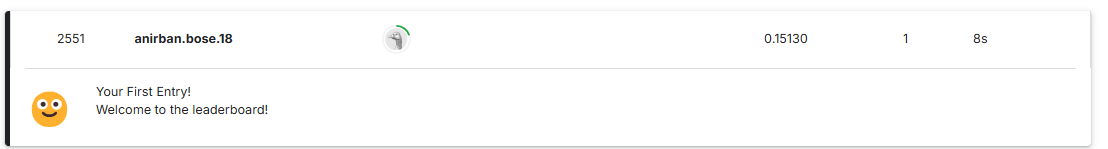

##### **Lasso**

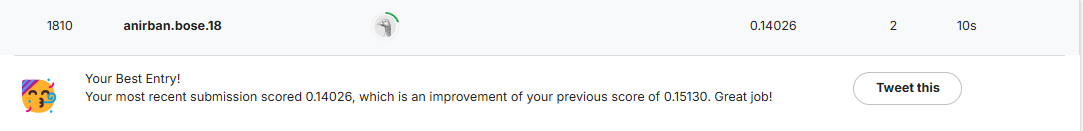

##### **Elasticnet**

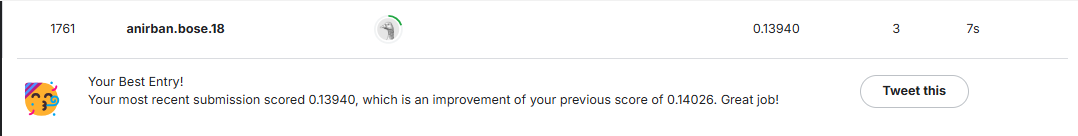